In [130]:
# Following https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb
# And also taking inspiration from https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

# Implementing Shor's Algorithm for N = 15

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.45.0', 'qiskit-aer': None, 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [47]:
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram
import math

In [51]:
def circuit_a_mod_15(qc: QuantumCircuit, qr: QuantumRegister, cr: ClassicalRegister, a: int):
    """
    The circuit for a^1 mod 15, a "subcircuit" of the main order-finding circuit
    
    a is an integer less than 15 that is also coprime with 15
    """
    
    if a == 2:
        # A CSWAP gate - first qbit is the control, second and third are the targets 
        qc.cswap(qr[4], qr[3], qr[2])
        qc.cswap(qr[4], qr[2], qr[1])
        qc.cswap(qr[4], qr[1], qr[0])
    elif a == 7:
        qc.cswap(qr[4], qr[1], qr[0])
        qc.cswap(qr[4], qr[2], qr[1])
        qc.cswap(qr[4], qr[3], qr[2])
        # A CNOT gate - first qbit is the control, second is the target
        qc.cx(qr[4], qr[3])
        qc.cx(qr[4], qr[2])
        qc.cx(qr[4], qr[1])
        qc.cx(qr[4], qr[0])
    elif a == 8:
        qc.cswap(qc[4], qc[1], qc[0])
        qc.cswap(qc[4], qc[2], qc[1])
        qc.cswap(qc[4], qc[3], qc[2])
    elif a == 11: # Because of the optimized circuit, this function is never called with a = 11, but this branch is included for completeness
        qc.cswap(qc[4], qc[2], qc[0])
        qc.cswap(qc[4], qc[3], qc[1])
        qc.cx(qc[4], qc[3])
        qc.cx(qc[4], qc[2])
        qc.cx(qc[4], qc[1])
        qc.cx(qc[4], qc[0])
    elif a == 13:
        qc.cswap(qc[4], qc[3], qc[2])
        qc.cswap(qc[4], qc[2], qc[1])
        qc.cswap(qc[4], qc[1], qc[0])
        qc.cx(qc[4], qc[3])
        qc.cx(qc[4], qc[2])
        qc.cx(qc[4], qc[1])
        qc.cx(qc[4], qc[0])
    else:
        raise ValueError("a must be less than and coprime with 15")

In [52]:
def circuit_11_period_15(qc: QuantumCircuit, qr: QuantumRegister, cr: ClassicalRegister):
    """
    The circuit for finding the period of 11^r mod 15.

    No parameter for `a` because this circuit is specifically for a = 11.

    This is separate from the other order finding circuits for other values of a because this has design has been optimized for a = 11. 
    """

    # Initialize q_0 to |1>
    qc.x(qr[0])

    # Apply a^4 mod 15
    qc.h(qr[4])
    # Controlled identity gate - q_4 is control, the rest are targets
    # But this is an identity gate. It doesn't do anything no matter the value of q_4.
    qc.h(qr[4])
    # Measure q_4
    qc.measure(qr[4], cr[0])
    # Reinitialize q_4 to |0>
    qc.reset(qr[4])

    # Apply a^2 mod 15
    qc.h(qr[4])
    # Controlled identity gate - q_4 is control, the rest are targets
    # But this is an identity gate. It doesn't do anything no matter the value of q_4.
    # Feed forward
    # Rotate q_4 by pi/2 if the classical register has the value 1 from the first measurement of q_4
    qc.p(math.pi/2, qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    # Measure q_4
    qc.measure(qr[4], cr[1])
    # Reinitialize q_4 to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    # CNOTs controlled by q_4 targetting q_3 and q_1
    qc.cx(qr[4], qr[3])
    qc.cx(qr[4], qr[1])
    # Feed forward
    # 4 possible values of the classical register:
    # 00, 01, 10, 11 (the first bit is the first measurement of q_4, the second bit is the second measurement of q_4)
    # rotation_amount = 0
    # if cr[0] == 1: rotation_amount += math.pi/2
    # if cr[1] == 1: rotation_amount += math.pi/4
    qc.p(3*math.pi/4, qr[4]).c_if(cr, 3) # Rotating math.pi/2 + math.pi/4 = 3*math.pi/4 if the classical register has the value 3 (11 in binary)
    qc.p(math.pi/2, qr[4]).c_if(cr, 2) # Rotating math.pi/2 if the classical register has the value 2 (10 in binary)
    qc.p(math.pi/4, qr[4]).c_if(cr, 1) # Rotating math.pi/4 if the classical register has the value 1 (01 in binary)
    qc.h(qr[4])
    # Measure q_4
    qc.measure(qr[4], cr[2])


In [53]:
def circuit_a_period_15(qc: QuantumCircuit, qr: QuantumRegister, cr: ClassicalRegister, a: int):
    """
    The circuit for a mod 15, a "subcircuit" of the main order-finding circuit
    
    a is an integer less than 15 that is also coprime with 15
    """

    if a == 11:
        # Use optimized circuit for 11 mod 15
        circuit_11_period_15(qc, qr, cr)
        return
    
    # Initialize q_0 to |1> (if you're reading from top to bottom, this is the 4th and final qbit)
    qc.x(qr[0])

    # Apply a^4 mod 15
    qc.h(qr[4])
    # Controlled identity gate - q_4 is control, the rest are targets
    # But this is an identity gate. It doesn't do anything no matter the value of q_4.
    qc.h(qr[4])
    # Measure q_4
    qc.measure(qr[4], cr[0])
    # Reinitialize q_4 to |0>
    qc.reset(qr[4])

    # Apply a^2 mod 15
    qc.h(qr[4])
    # CNOTs controlled by q_4 targetting q_2 and q_0
    qc.cx(qr[4], qr[2])
    qc.cx(qr[4], qr[0])
    # Feed forward
    # Rotate q_4 by pi/2 if the classical register has the value 1 from the first measurement of q_4
    qc.p(math.pi/2, qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    # Measure q_4
    qc.measure(qr[4], cr[1])
    # Reinitialize q_4 to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    # Controlled a_mod_15 gate - q_4 is control, the rest are targets
    circuit_a_mod_15(qc, qr, cr, a)
    # Feed forward
    # 4 possible values of the classical register:
    # 00, 01, 10, 11 (the first bit is the first measurement of q_4, the second bit is the second measurement of q_4)
    # rotation_amount = 0
    # if cr[0] == 1: rotation_amount += math.pi/2
    # if cr[1] == 1: rotation_amount += math.pi/4
    qc.p(3*math.pi/4, qr[4]).c_if(cr, 3) # Rotating math.pi/2 + math.pi/4 = 3*math.pi/4 if the classical register has the value 3 (11 in binary)
    qc.p(math.pi/2, qr[4]).c_if(cr, 2) # Rotating math.pi/2 if the classical register has the value 2 (10 in binary)
    qc.p(math.pi/4, qr[4]).c_if(cr, 1) # Rotating math.pi/4 if the classical register has the value 1 (01 in binary)
    qc.h(qr[4])
    # Measure q_4
    qc.measure(qr[4], cr[2])


## Building and running the circuit

d:\Samihan\Documents\ASU\Year 5\Fall Semester\CSE 598\Project\.venv\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


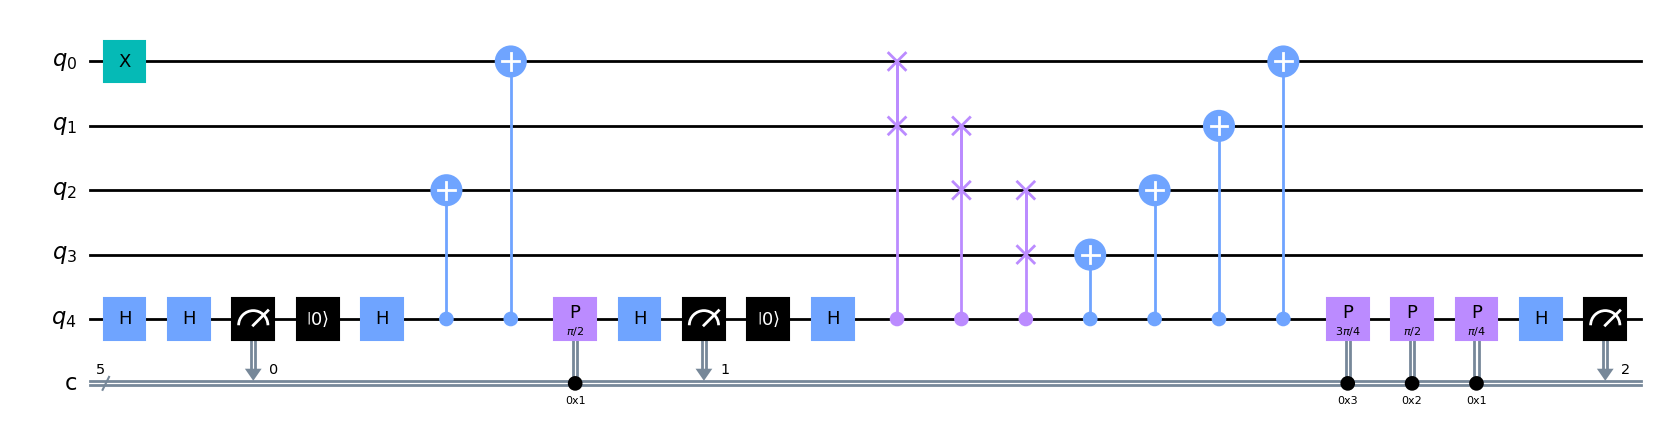

In [121]:
NUM_QUBITS = 5
q = QuantumRegister(NUM_QUBITS, 'q')
c = ClassicalRegister(5, 'c')

# a_values_to_try = [2, 7, 8, 11, 13] # NOTE: Not all of these work (i.e. some throw an error and others don't find the factors nearly as quickly as a = 7 (or at all?)) 
a = 7

shor_circuit = QuantumCircuit(q, c)
circuit_a_period_15(shor_circuit, q, c, a)
shor_circuit.draw(output='mpl')

## Distribution of measurements

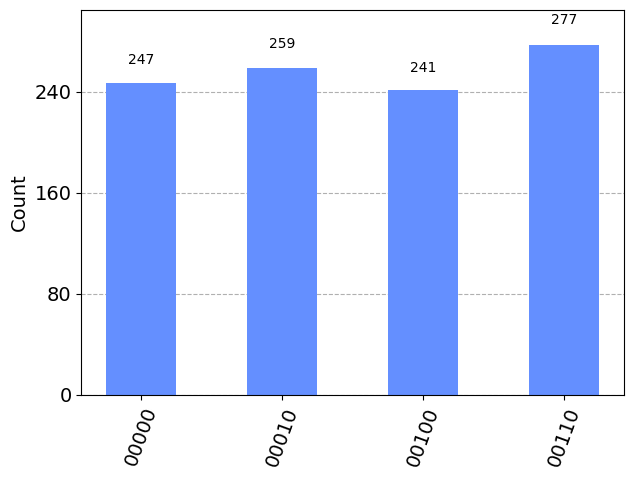

In [122]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(shor_circuit, backend, shots=1024)
result = job.result()
data = result.get_counts(shor_circuit)
plot_histogram(data)

## Running queries iteratively to find the factors of N = 15

In [128]:
# Determine period from the results

did_find_period = False

from fractions import Fraction

total_queries = 0

while did_find_period is False:
    total_queries += 1
    job = execute(shor_circuit, backend, shots=1)
    result = job.result()
    data = result.get_counts(shor_circuit)
    # Convert the measurement to an integer
    # Binary string to decimal
    decimal_measurement = int(list(data.keys())[0], 2)

    # This is our clue from the lecture notes
    # s = kN/L where N = 2^n (where n is the number of qubits), L is the period, and 0 <= k < L (randomly picked)
    # Use the continued fraction method to approximate the fraction k/L in lowest terms

    if decimal_measurement == 0:
        # Any approximated fraction of 0 is 0, so we won't learn anything from this measurement
        print("Measurement is 0, trying again")
        continue

    print(f"Measurement is {decimal_measurement}")

    # -> s/N = s/2^n ≈ k/L
    # Get the continued fraction approximation of s/2^n and take the denominator as the guess for L
    fraction = Fraction(decimal_measurement, 2**NUM_QUBITS).limit_denominator(15) # Limit the value of L to be less than 15 because we know the period has to be less than 15
    print(f"Result of continued fraction expansion = {fraction}")

    guess_for_r = fraction.denominator

    print(f"Guess for r = {guess_for_r}")

    # If R^2 mod N = 1, then we can solve for P and Q
    # Otherwise, we'll have to try again
    if (guess_for_r**2) % 15 != 1:
        print(f"r^2 mod 15 = {(guess_for_r**2) % 15} and not 1, trying again")
        continue
    
    # Solve for P and Q using the formula from the lecture notes
    # P = gcd(r-1, N)
    # Q = gcd(r+1, N)
    p = math.gcd(guess_for_r - 1, 15)
    q = math.gcd(guess_for_r + 1, 15)

    if p != 1 and q != 1 and p*q == 15:
        print(f"Found factors p = {p}, q = {q}")
        print(f"Required {total_queries} queries of the circuit.")
        did_find_period = True
    

Measurement is 6
Result of continued fraction expansion = 2/11
Guess for r = 11
Found factors p = 5, q = 3
Required 1 queries of the circuit.
